#The Impact of Climate on PV

In [1]:
#mount to google drive first
import io
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


### Load Libraries

In [2]:
#Data Cleaning
import pandas as pd
import numpy as np
import missingno as msno # for dealing with missing values
import datetime as dt
from pytz import timezone

#Data Exploration
import seaborn as sns
import matplotlib.pyplot as plt

#Data modelling
from statsmodels import api as sm # tp perform regression
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Data

### Merging Data

In [ ]:
path = "/content/drive/My Drive/UNIVERSITY/Sem 4 - 2020/IFN - 704/Data/"
xls = pd.ExcelFile(path+ 'site_details.xlsx')
meta = pd.read_excel(xls, 'site_details')
solar = pd.read_csv(path+"solar.csv")
weather = pd.read_csv(path+"brisbane.csv")
sol = pd.read_csv(path+"sol.csv")

In [4]:
solar["t_stamp_utc"] = pd.to_datetime(solar["t_stamp_utc"])
solar["date_time"] = solar["t_stamp_utc"].dt.tz_convert(timezone("Australia/Brisbane"))
solar.set_index(solar["date_time"], inplace=True)
solar.drop(columns = ["Unnamed: 0", "site_id", "t_stamp_utc", "date_time"], inplace=True)
solar = solar.resample('H').sum()

In [5]:
sol['date_time'] = pd.to_datetime(sol[['Year', 'Month', 'Day', 'Hour']])
sol["date_time"] = sol["date_time"].dt.tz_localize("Australia/Brisbane")
sol.set_index(sol["date_time"], inplace=True)
sol.drop(columns = ['Year',	'Month',	'Day',	'Hour',	'Minute', 'date_time'], inplace = True)

In [6]:
solar.head()

energy_(Wh)
date_time                             
2019-01-01 10:00:00+10:00    3145.1667
2019-01-01 11:00:00+10:00    3501.3216
2019-01-01 12:00:00+10:00    3677.0579
2019-01-01 13:00:00+10:00    3669.4784
2019-01-01 14:00:00+10:00    3429.3342

In [7]:
weather.head()

date_time  maxtempC  ...  windspeedKmph  location
0  2019-01-01 00:00:00        29  ...             14  brisbane
1  2019-01-01 01:00:00        29  ...             13  brisbane
2  2019-01-01 02:00:00        29  ...             12  brisbane
3  2019-01-01 03:00:00        29  ...             11  brisbane
4  2019-01-01 04:00:00        29  ...             11  brisbane

[5 rows x 25 columns]

In [8]:
sol.head()

Albedo  DHI  DNI  ...  GHI  GtiFixedTilt  GtiTracking
date_time                                    ...                                
2019-01-01 00:00:00+10:00     0.1    0    0  ...    0             0            0
2019-01-01 01:00:00+10:00     0.1    0    0  ...    0             0            0
2019-01-01 02:00:00+10:00     0.1    0    0  ...    0             0            0
2019-01-01 03:00:00+10:00     0.1    0    0  ...    0             0            0
2019-01-01 04:00:00+10:00     0.1    0    0  ...    0             0            0

[5 rows x 7 columns]

In [9]:
weather["date_time"] = pd.to_datetime(weather["date_time"])
weather["date_time"] = weather["date_time"].dt.tz_localize("Australia/Brisbane")
weather.set_index(weather["date_time"], inplace=True)
#drop useless columns
weather.drop(columns=["maxtempC",	"mintempC", "date_time",	"totalSnow_cm",	"sunHour"	, "moon_illumination",	"moonrise",	"moonset",	"sunrise",	"sunset", "DewPointC",	"FeelsLikeC",	"HeatIndexC", "WindChillC",	"WindGustKmph", "location"], inplace= True)

In [10]:
#merge all data
temp = pd.merge(solar, weather, how="left", on= "date_time")
data = pd.merge(temp, sol, how="left", on= "date_time")
data.rename(columns= {"energy_(Wh)": "energy"}, inplace=True)
data = data.dropna()

In [11]:
data.head()

energy  uvIndex  ...  GtiFixedTilt  GtiTracking
date_time                                      ...                           
2019-01-01 10:00:00+10:00  3145.1667      7.0  ...           955         1080
2019-01-01 11:00:00+10:00  3501.3216      7.0  ...          1019         1089
2019-01-01 12:00:00+10:00  3677.0579      7.0  ...          1007         1088
2019-01-01 13:00:00+10:00  3669.4784      7.0  ...           920         1075
2019-01-01 14:00:00+10:00  3429.3342      7.0  ...           766         1046

[5 rows x 17 columns]

In [12]:
#drop all rows for which there is no sunlight
data.drop(data[data['energy'] < 5].index, inplace = True)

#droppin THOSE clear outliers
data.drop(data[data["energy"]>5000].index, inplace = True)

#drop the row that has outlier temp
data.drop(data[data["tempC"]<2].index, inplace = True)

In [13]:
#print outliers
z = np.abs(stats.zscore(data))
print(np.where(z > 3))

(array([  29,   72,   73,   86,   98,   99,  100,  127,  477,  478,  479,
        493,  494,  495,  496,  506,  531,  532,  533,  534,  545,  546,
        547,  548,  549,  550,  551,  552,  553,  554,  555,  556,  557,
        566,  567,  568,  569,  570,  571,  579,  580,  581,  582,  583,
        584,  594,  595,  608,  609,  610,  611,  612,  613,  616,  621,
        622,  623,  624,  625,  625,  627,  637,  647,  648,  649,  650,
        651,  660,  661,  662,  663,  664,  676,  677,  712,  713,  714,
        715,  716,  717,  718,  719,  720,  721,  731,  732,  733,  734,
        735,  736,  737,  747,  748,  749,  750,  771,  820,  971,  977,
        988,  989,  990,  991,  992,  993,  994,  995,  996,  997, 1000,
       1002, 1003, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019,
       1020, 1021, 1022, 1122, 1124, 1125, 1126, 1127, 1128, 1129, 1130,
       1131, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152,
       1153, 1154, 1155, 1156, 1157, 1158, 1159, 1

# Data Exploration

In [14]:
data.head()

energy  uvIndex  ...  GtiFixedTilt  GtiTracking
date_time                                      ...                           
2019-01-01 10:00:00+10:00  3145.1667      7.0  ...           955         1080
2019-01-01 11:00:00+10:00  3501.3216      7.0  ...          1019         1089
2019-01-01 12:00:00+10:00  3677.0579      7.0  ...          1007         1088
2019-01-01 13:00:00+10:00  3669.4784      7.0  ...           920         1075
2019-01-01 14:00:00+10:00  3429.3342      7.0  ...           766         1046

[5 rows x 17 columns]

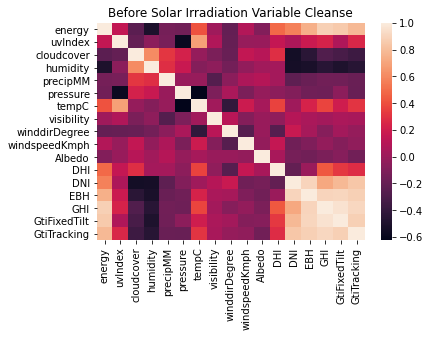

In [15]:
sns.heatmap(data.corr())
plt.title("Before Solar Irradiation Variable Cleanse")
plt.show()

In [16]:
## GHI has the highest correlation with energy so it will be kept, as will DHI, for now.

In [17]:
data.drop(columns=["DNI",	"EBH", "GtiFixedTilt",	"GtiTracking"], inplace=True)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4471 entries, 2019-01-01 10:00:00+10:00 to 2019-12-31 18:00:00+10:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   energy         4471 non-null   float64
 1   uvIndex        4471 non-null   float64
 2   cloudcover     4471 non-null   float64
 3   humidity       4471 non-null   float64
 4   precipMM       4471 non-null   float64
 5   pressure       4471 non-null   float64
 6   tempC          4471 non-null   float64
 7   visibility     4471 non-null   float64
 8   winddirDegree  4471 non-null   float64
 9   windspeedKmph  4471 non-null   float64
 10  Albedo         4471 non-null   float64
 11  DHI            4471 non-null   int64  
 12  GHI            4471 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 489.0 KB


In [19]:
data.describe()

energy      uvIndex  ...          DHI          GHI
count  4471.000000  4471.000000  ...  4471.000000  4471.000000
mean   1641.023472     5.749720  ...   157.765824   437.175576
std    1144.502857     0.977251  ...   127.903578   297.276792
min       5.047300     4.000000  ...     0.000000     0.000000
25%     555.912400     5.000000  ...    64.000000   171.000000
50%    1583.442300     6.000000  ...   117.000000   422.000000
75%    2644.883050     6.000000  ...   220.000000   654.500000
max    4198.865400     8.000000  ...   697.000000  1140.000000

[8 rows x 13 columns]

In [20]:
data.isna().sum()

energy           0
uvIndex          0
cloudcover       0
humidity         0
precipMM         0
pressure         0
tempC            0
visibility       0
winddirDegree    0
windspeedKmph    0
Albedo           0
DHI              0
GHI              0
dtype: int64

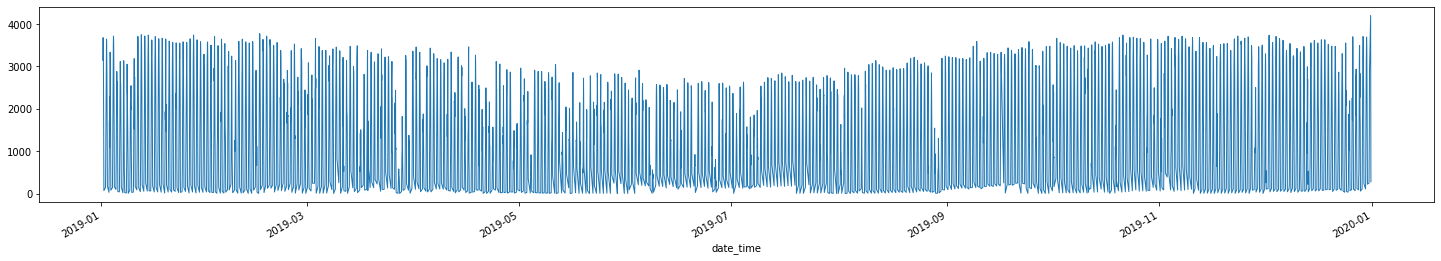

In [21]:
data['energy'].plot(linewidth=1, figsize = (25, 4));

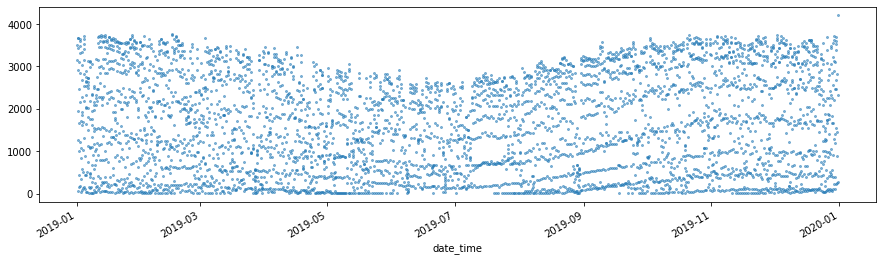

In [ ]:
data['energy'].plot(marker='.', alpha=0.5, markersize=4, 
linestyle='None', figsize = (15, 4))

In [ ]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['energy', "uvIndex",	"cloudcover",	"humidity",	"precipMM",	"pressure",	"tempC"	,"visibility"	,"winddirDegree",	"windspeedKmph", "Albedo",	"DHI",		"GHI"]
# Resample to weekly frequency, aggregating with mean
data_weekly_mean = data[data_columns].resample('W').mean()
# Resample to daily frequency, aggregating with mean
data_daily_mean = data[data_columns].resample('D').mean()

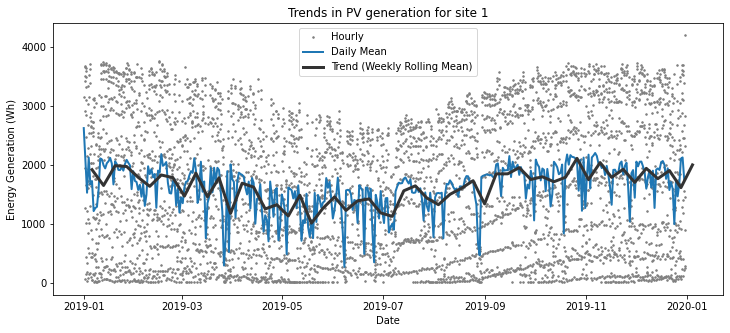

In [ ]:
# Plot hourly, daily rolling mean, and 7-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(data['energy'], marker='.', markersize=3, color='0.5',
linestyle='None',  label='Hourly') # , hue=data.index, palette ="coolwarm"
ax.plot(data_daily_mean['energy'], linewidth=2, label='Daily Mean')
ax.plot(data_weekly_mean['energy'], color='0.2', linewidth=3,
label='Trend (Weekly Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
fig.set_figheight(5)
fig.set_figwidth(12)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Energy Generation (Wh)')
ax.set_title('Trends in PV generation for site 1');

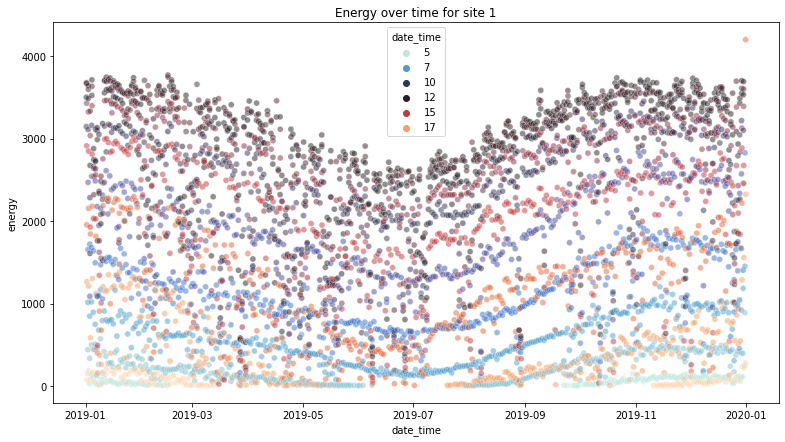

In [ ]:
plt.figure(figsize=(13,7))
sns.scatterplot(y=data['energy'], x=data.index, hue = data.index.hour, palette ="icefire", alpha=0.5)
plt.title("Energy over time for site 1")
plt.show()

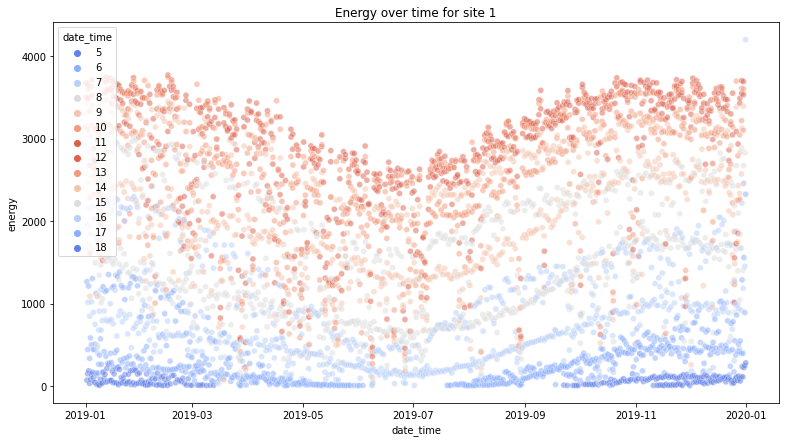

In [ ]:
##Shows the actual impact the psoition of the sun has on PV

#create my own colour pallet
mypal = sns.color_palette("coolwarm", 7) + sns.color_palette("coolwarm_r", 7)

plt.figure(figsize=(13,7))
sns.scatterplot(y=data['energy'], x=data.index, hue = data.index.hour, palette =mypal, alpha=0.5)
plt.title("Energy over time for site 1")
plt.show()

In [ ]:
data_meanClouds = data.drop(data[data['cloudcover'] > 36].index)
data_notmeanClouds = data.drop(data[data['cloudcover'] < 36].index)

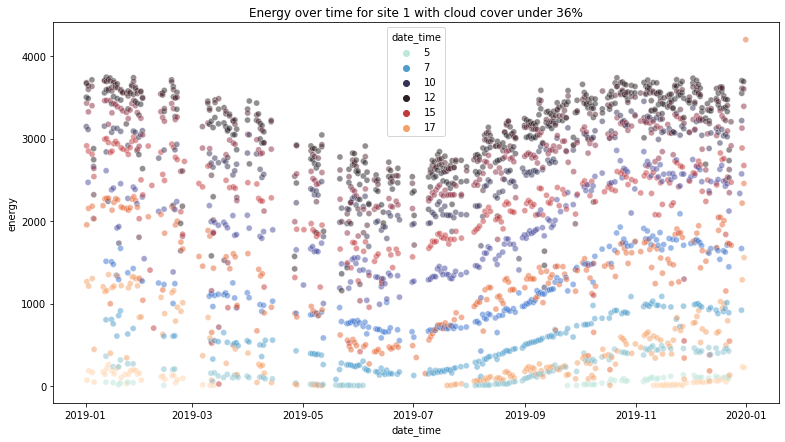

In [ ]:
plt.figure(figsize=(13,7))
sns.scatterplot(y=data_meanClouds['energy'], x=data_meanClouds.index, hue = data_meanClouds.index.hour, palette ="icefire", alpha=0.5)
plt.title("Energy over time for site 1 with cloud cover under 36%")
plt.show()

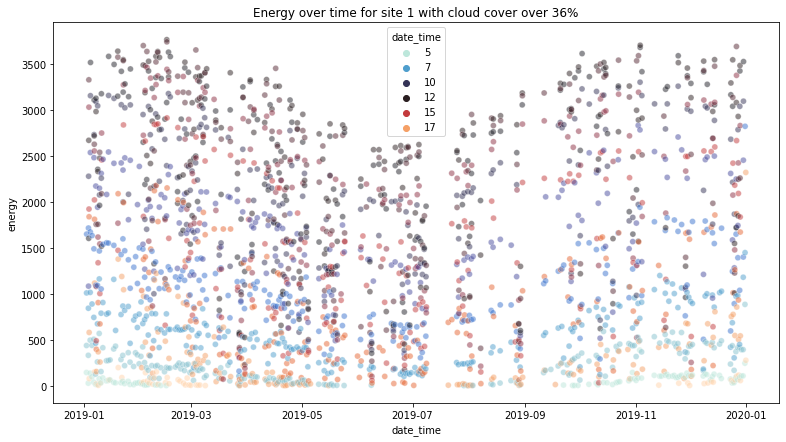

In [ ]:
plt.figure(figsize=(13,7))
sns.scatterplot(y=data_notmeanClouds['energy'], x=data_notmeanClouds.index, hue = data_notmeanClouds.index.hour, palette ="icefire", alpha=0.5)
plt.title("Energy over time for site 1 with cloud cover over 36%")
plt.show()

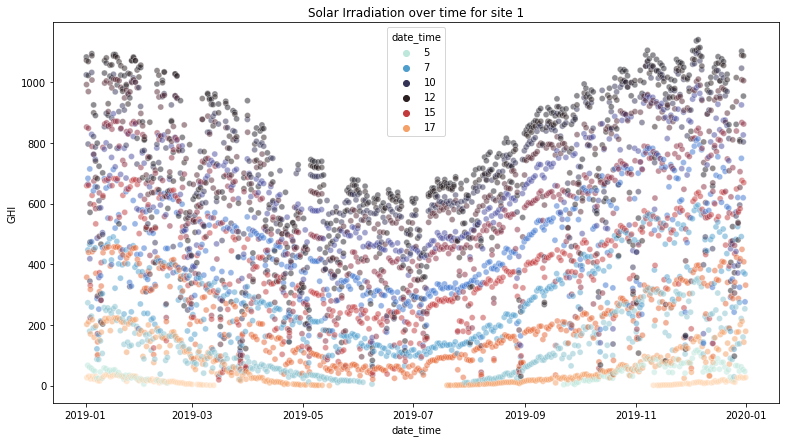

In [ ]:
plt.figure(figsize=(13,7))
sns.scatterplot(y=data['GHI'], x=data.index, hue = data.index.hour, palette ="icefire", alpha=0.5)
plt.title("Solar Irradiation over time for site 1")
plt.show()

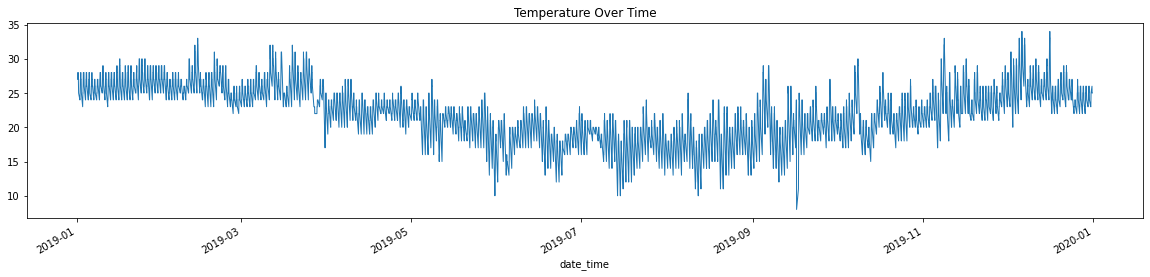

In [ ]:
data['tempC'].plot(linewidth=1, figsize = (20, 4), title = "Temperature Over Time");

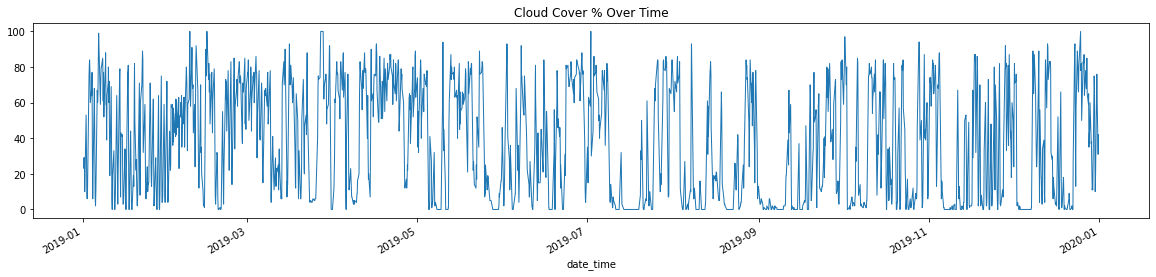

In [ ]:
data['cloudcover'].plot(linewidth=1, figsize = (20, 4), title = "Cloud Cover % Over Time");

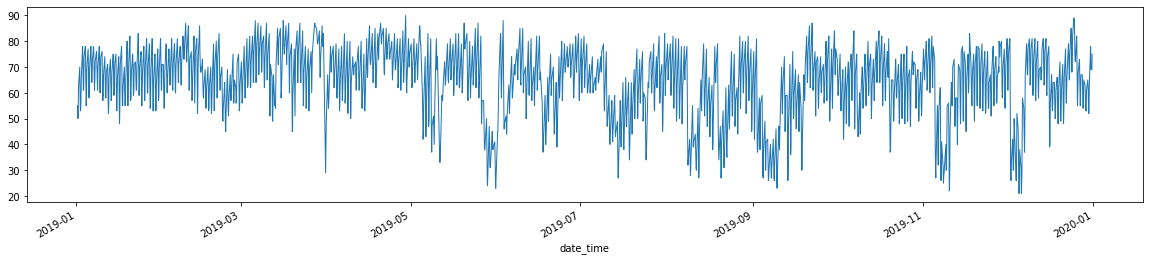

In [ ]:
data['humidity'].plot(linewidth=1, figsize = (20, 4));

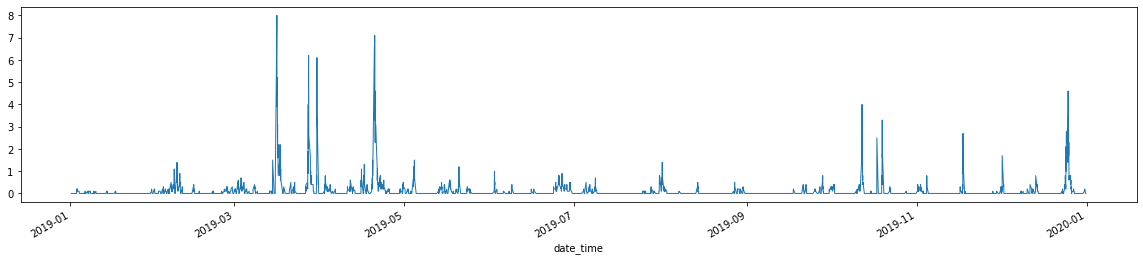

In [ ]:
data['precipMM'].plot(linewidth=1, figsize = (20, 4));

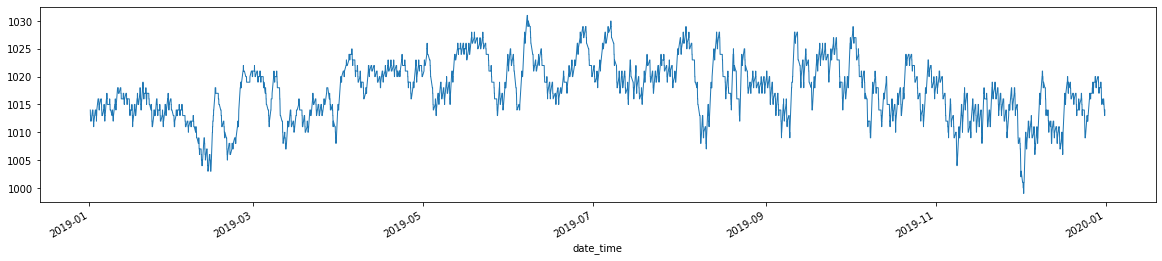

In [ ]:
data['pressure'].plot(linewidth=1, figsize = (20, 4));

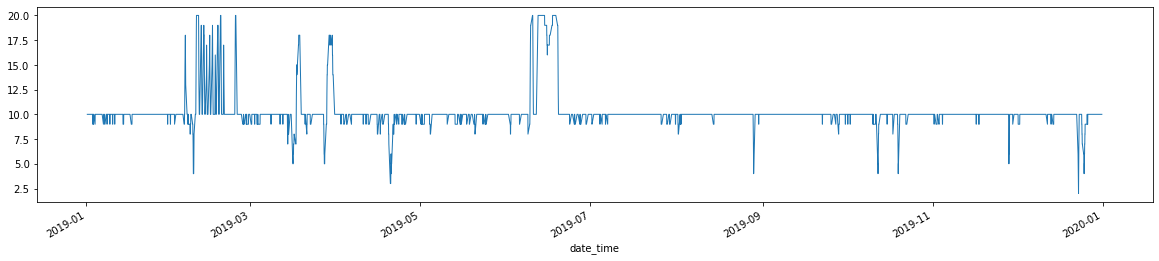

In [ ]:
data['visibility'].plot(linewidth=1, figsize = (20, 4));

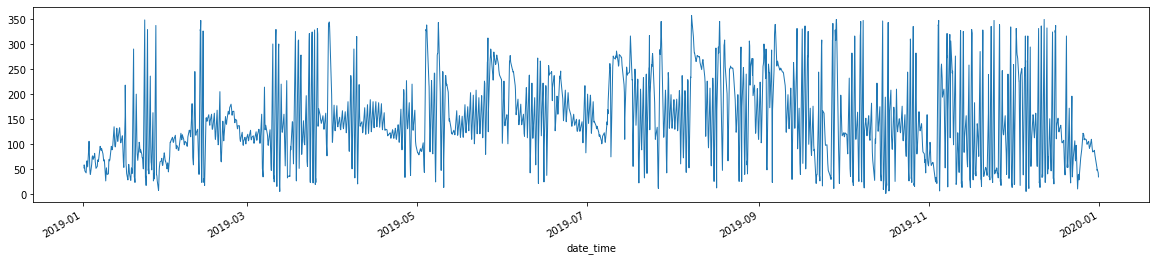

In [ ]:
data['winddirDegree'].plot(linewidth=1, figsize = (20, 4));

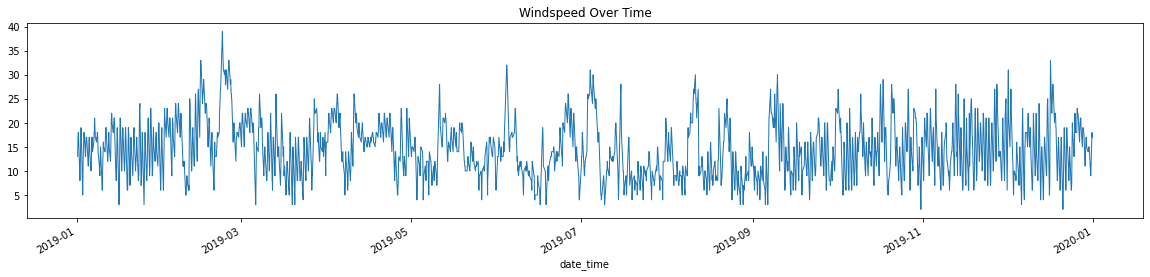

In [ ]:
data['windspeedKmph'].plot(linewidth=1, figsize = (20, 4), title = "Windspeed Over Time");

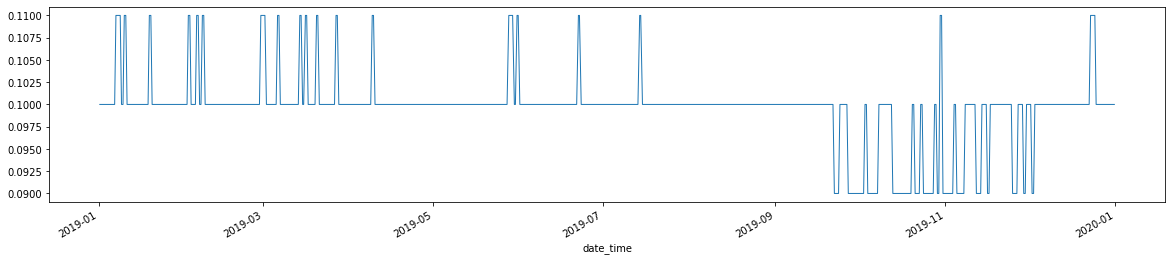

In [ ]:
data['Albedo'].plot(linewidth=1, figsize = (20, 4));

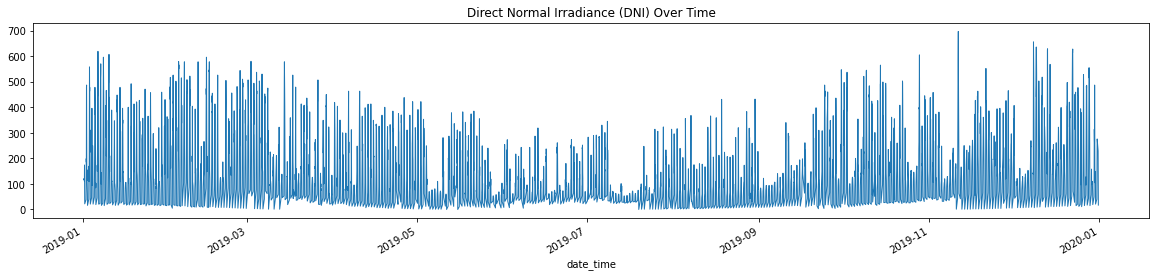

In [ ]:
data['DHI'].plot(linewidth=1, figsize = (20, 4), title = "Direct Normal Irradiance (DNI) Over Time");

In [ ]:
#data['DNI'].plot(linewidth=1, figsize = (20, 4));

In [ ]:
#data['EBH'].plot(linewidth=1, figsize = (20, 4));

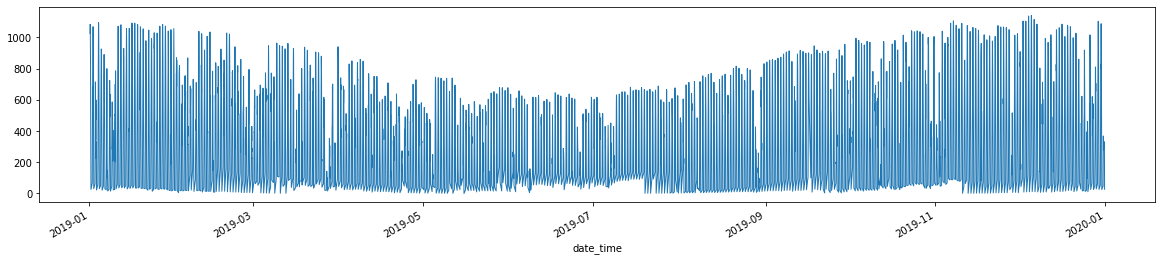

In [ ]:
data['GHI'].plot(linewidth=1, figsize = (20, 4));

In [ ]:
#data['GtiFixedTilt'].plot(linewidth=1, figsize = (20, 4));

In [ ]:
#data['GtiTracking'].plot(linewidth=1, figsize = (20, 4));

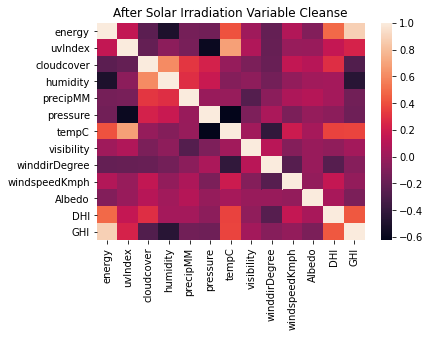

In [ ]:
sns.heatmap(data.corr())
plt.title("After Solar Irradiation Variable Cleanse")
plt.show()

In [ ]:
sns.pairplot(data, diag_kind='hist')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

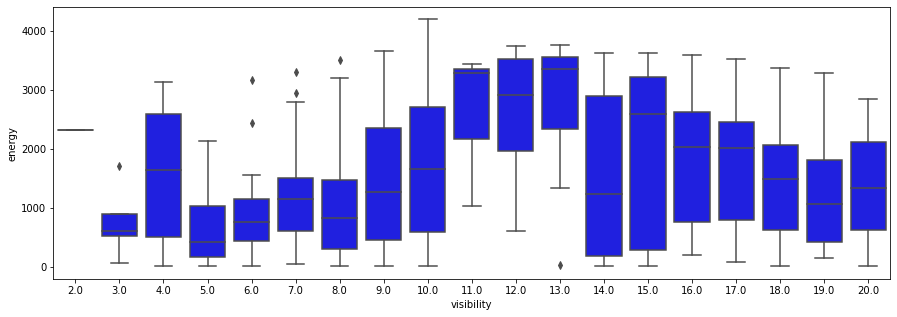

In [ ]:
plt.figure(figsize=(15,5))
sns.boxplot(x=data["visibility"], y = data["energy"], color = "blue")

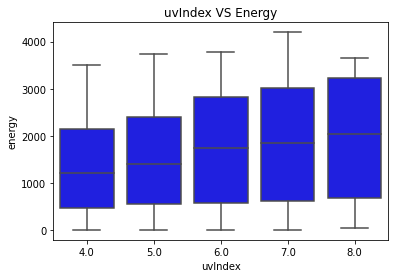

In [ ]:
sns.boxplot(x=data["uvIndex"], y = data["energy"], color = "blue")
plt.title("uvIndex VS Energy")
plt.show()

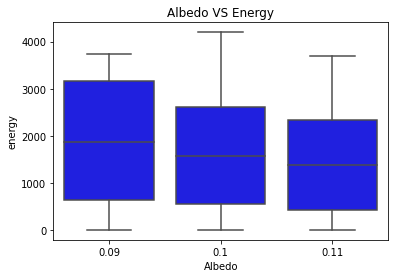

In [ ]:
#plt.figure(figsize=(10,5))
sns.boxplot(x=data["Albedo"], y = data["energy"], color = "blue")
plt.title("Albedo VS Energy")
plt.show()

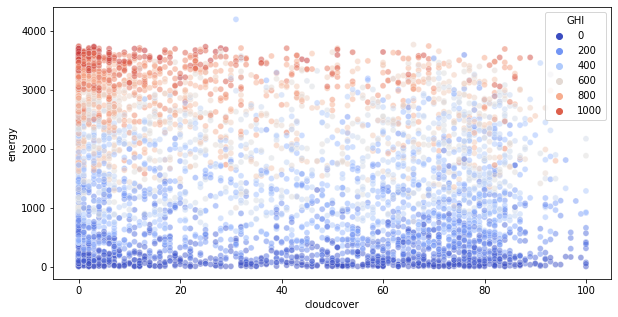

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=data["cloudcover"], y = data["energy"], alpha=0.5, hue=data['GHI'], palette ="coolwarm")
#'', "",	"",	"",	"",	"pressure",	"tempC"	,"visibility"	,"winddirDegree",	"windspeedKmph", "Albedo",	"DHI",		"GHI"

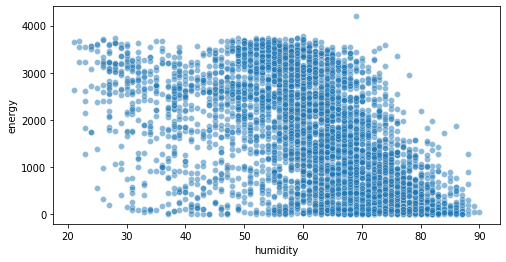

In [ ]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=data["humidity"], y = data["energy"], alpha=0.5, palette ="coolwarm")

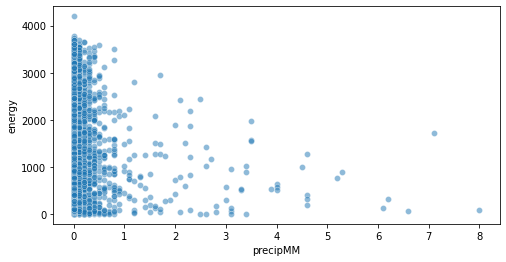

In [ ]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=data["precipMM"], y = data["energy"], alpha=0.5,  palette ="coolwarm")

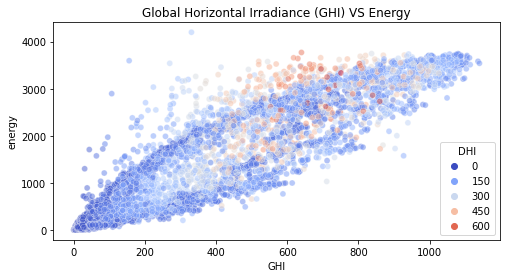

In [ ]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=data["GHI"], y = data["energy"], alpha=0.5, hue=data['DHI'], palette ="coolwarm")
plt.title("Global Horizontal Irradiance (GHI) VS Energy")
plt.show()

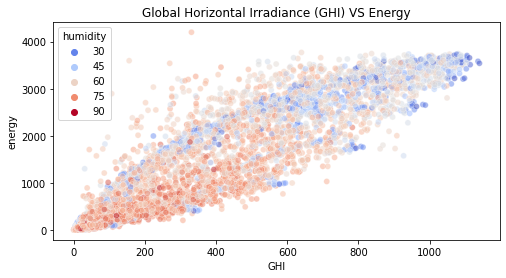

In [ ]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=data["GHI"], y = data["energy"], alpha=0.5, hue=data['humidity'], palette ="coolwarm")
plt.title("Global Horizontal Irradiance (GHI) VS Energy")
plt.show()

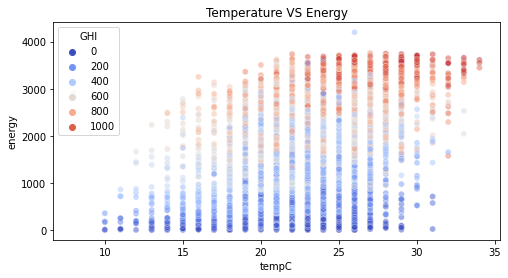

In [ ]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=data["tempC"], y = data["energy"], alpha=0.5,  hue=data['GHI'],palette ="coolwarm", x_jitter= 5,)
plt.title("Temperature VS Energy")
plt.show()

# Modelling

In [ ]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
import statsmodels.api as sm
X = data.iloc[:,1:]
X_con = sm.add_constant(X)
y = data["energy"]
logit_model=sm.OLS(y,X_con)
result=logit_model.fit()
print(result.summary2())

                    Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.859     
Dependent Variable:    energy            AIC:                 66928.9833
Date:                  2020-10-22 04:58  BIC:                 67012.2530
No. Observations:      4471              Log-Likelihood:      -33451.   
Df Model:              12                F-statistic:         2264.     
Df Residuals:          4458              Prob (F-statistic):  0.00      
R-squared:             0.859             Scale:               1.8513e+05
------------------------------------------------------------------------
                Coef.     Std.Err.    t     P>|t|    [0.025     0.975]  
------------------------------------------------------------------------
const         -4834.1829 1882.0134  -2.5686 0.0102 -8523.8631 -1144.5027
uvIndex        -207.1543   10.0686 -20.5743 0.0000  -226.8938  -187.4148
cloudcover       -0.9886    0.3046  -3.2452 0.0012    -1.5858    -0.3913

In [ ]:
model = forward_selected(data, "energy")

In [ ]:
print(model.model.formula)

energy ~ GHI + winddirDegree + humidity + DHI + uvIndex + tempC + Albedo + windspeedKmph + pressure + cloudcover + visibility + 1


In [ ]:
print(model.summary2())

                    Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.859     
Dependent Variable:    energy            AIC:                 66927.3054
Date:                  2020-10-22 04:58  BIC:                 67004.1698
No. Observations:      4471              Log-Likelihood:      -33452.   
Df Model:              11                F-statistic:         2470.     
Df Residuals:          4459              Prob (F-statistic):  0.00      
R-squared:             0.859             Scale:               1.8510e+05
------------------------------------------------------------------------
                Coef.     Std.Err.    t     P>|t|    [0.025     0.975]  
------------------------------------------------------------------------
Intercept     -4672.8274 1860.2144  -2.5120 0.0120 -8319.7706 -1025.8842
GHI               2.7270    0.0304  89.6283 0.0000     2.6673     2.7866
winddirDegree    -1.6193    0.0958 -16.9032 0.0000    -1.8071    -1.4315

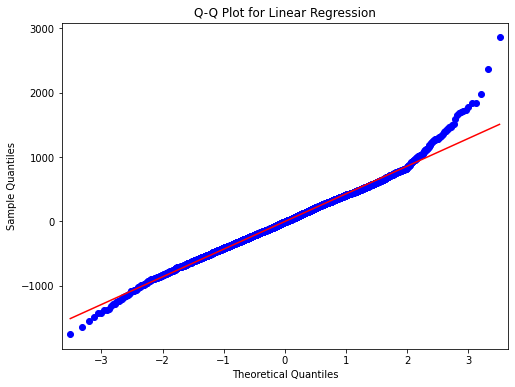

In [ ]:
#QQ plot
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model.resid, ax=ax, line='s' )
plt.title('Q-Q Plot for Linear Regression')
plt.show()

In [ ]:
#The many normality tests for residuals

jb = stats.jarque_bera(model.resid)
sw = stats.shapiro(model.resid)
ad = stats.anderson(model.resid, dist='norm')
ks = stats.kstest(model.resid, 'norm')
    
print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    

Jarque-Bera test ---- statistic: 367.4060, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9904, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5010, p-value: 0.0000
Anderson-Darling test ---- statistic: 2.8016, 5% critical value: 0.7860
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


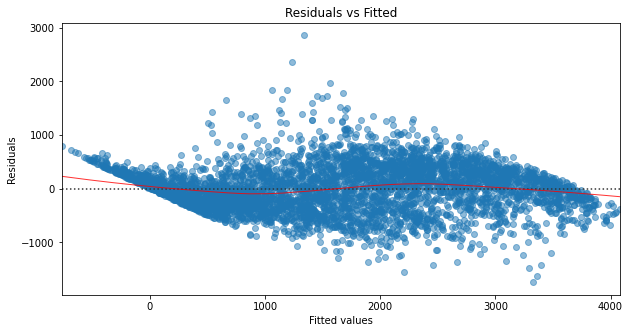

In [ ]:
plot_lm_1 = plt.figure(figsize= (10,5))
plot_lm_1.axes[0] = sns.residplot(model.fittedvalues, y, data=data, 
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [ ]:
#explored interaction a little, but out of scope
from statsmodels.formula.api import ols

formula = 'energy ~ (cloudcover +	precipMM + winddirDegree + windspeedKmph + DHI + GHI)** 2 + 1'
interaction = ols(formula, data ).fit()
print(interaction.summary2())

                         Results: Ordinary least squares
Model:                    OLS                  Adj. R-squared:         0.827     
Dependent Variable:       energy               AIC:                    67829.4139
Date:                     2020-10-22 04:59     BIC:                    67970.3320
No. Observations:         4471                 Log-Likelihood:         -33893.   
Df Model:                 21                   F-statistic:            1022.     
Df Residuals:             4449                 Prob (F-statistic):     0.00      
R-squared:                0.828                Scale:                  2.2598e+05
---------------------------------------------------------------------------------
                              Coef.   Std.Err.    t     P>|t|    [0.025   0.975] 
---------------------------------------------------------------------------------
Intercept                    391.8724  81.5304   4.8065 0.0000  232.0323 551.7126
cloudcover                    -2.6524   1

# Adding new Site

In [ ]:
solar2 = pd.read_csv(path+"solar_2.csv")

In [ ]:
solar2.head()

Unnamed: 0                t_stamp_utc   site_id  energy_(Wh)
0           0  2019-01-01 00:00:00+00:00  77491219     241.0831
1           1  2019-01-01 00:05:00+00:00  77491219     247.4711
2           2  2019-01-01 00:10:00+00:00  77491219     253.3197
3           3  2019-01-01 00:15:00+00:00  77491219     257.6561
4           4  2019-01-01 00:20:00+00:00  77491219     262.9206

In [ ]:
solar2["t_stamp_utc"] = pd.to_datetime(solar2["t_stamp_utc"])
solar2["date_time"] = solar2["t_stamp_utc"].dt.tz_convert(timezone("Australia/Brisbane"))
solar2.set_index(solar2["date_time"], inplace=True)
solar2.drop(columns = ["Unnamed: 0", "site_id", "t_stamp_utc", "date_time"], inplace=True)
solar2 = solar2.resample('H').sum()
solar2.head()

energy_(Wh)
date_time                             
2019-01-01 10:00:00+10:00    3233.8229
2019-01-01 11:00:00+10:00    3797.0104
2019-01-01 12:00:00+10:00    4111.0903
2019-01-01 13:00:00+10:00    4227.2711
2019-01-01 14:00:00+10:00    4117.7986

In [ ]:
temp2 = pd.merge(solar2, weather, how="left", on= "date_time")
data2 = pd.merge(temp2, sol, how="left", on= "date_time")
data2.rename(columns= {"energy_(Wh)": "energy"}, inplace=True)
data2 = data2.dropna()
data2.head()

energy  uvIndex  ...  GtiFixedTilt  GtiTracking
date_time                                      ...                           
2019-01-01 10:00:00+10:00  3233.8229      7.0  ...           955         1080
2019-01-01 11:00:00+10:00  3797.0104      7.0  ...          1019         1089
2019-01-01 12:00:00+10:00  4111.0903      7.0  ...          1007         1088
2019-01-01 13:00:00+10:00  4227.2711      7.0  ...           920         1075
2019-01-01 14:00:00+10:00  4117.7986      7.0  ...           766         1046

[5 rows x 17 columns]

In [ ]:
#drop all rows for which there is no sunlight
data2.drop(data2[data2['energy'] < 5].index, inplace = True)

#droppin THOSE clear outliers
data2.drop(data2[data2["energy"]>5000].index, inplace = True)

#drop the row that has 0 temp
data2.drop(data2[data2["tempC"]<2].index, inplace = True)

In [ ]:
data2.drop(columns=["DNI",	"EBH", "GtiFixedTilt",	"GtiTracking"], inplace=True)

In [ ]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['energy', "uvIndex",	"cloudcover",	"humidity",	"precipMM",	"pressure",	"tempC"	,"visibility"	,"winddirDegree",	"windspeedKmph", "Albedo",	"DHI",		"GHI"]
# Resample to weekly frequency, aggregating with mean
data_weekly_mean = data2[data_columns].resample('W').mean()
# Resample to daily frequency, aggregating with mean
data_daily_mean = data2[data_columns].resample('D').mean()

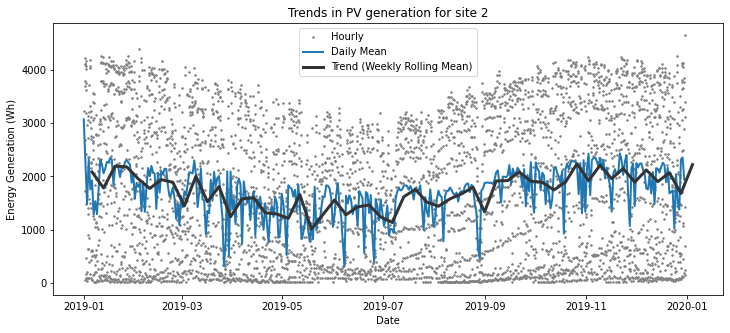

In [ ]:
# Plot hourly, daily rolling mean, and 7-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(data2['energy'], marker='.', markersize=3, color='0.5',
linestyle='None',  label='Hourly')
ax.plot(data_daily_mean['energy'], linewidth=2, label='Daily Mean')
ax.plot(data_weekly_mean['energy'], color='0.2', linewidth=3,
label='Trend (Weekly Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
fig.set_figheight(5)
fig.set_figwidth(12)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Energy Generation (Wh)')
ax.set_title('Trends in PV generation for site 2');

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4471 entries, 2019-01-01 10:00:00+10:00 to 2019-12-31 18:00:00+10:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   energy         4471 non-null   float64
 1   uvIndex        4471 non-null   float64
 2   cloudcover     4471 non-null   float64
 3   humidity       4471 non-null   float64
 4   precipMM       4471 non-null   float64
 5   pressure       4471 non-null   float64
 6   tempC          4471 non-null   float64
 7   visibility     4471 non-null   float64
 8   winddirDegree  4471 non-null   float64
 9   windspeedKmph  4471 non-null   float64
 10  Albedo         4471 non-null   float64
 11  DHI            4471 non-null   int64  
 12  GHI            4471 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 489.0 KB


In [ ]:
data = data.append(data2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8878 entries, 2019-01-01 10:00:00+10:00 to 2019-12-31 18:00:00+10:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   energy         8878 non-null   float64
 1   uvIndex        8878 non-null   float64
 2   cloudcover     8878 non-null   float64
 3   humidity       8878 non-null   float64
 4   precipMM       8878 non-null   float64
 5   pressure       8878 non-null   float64
 6   tempC          8878 non-null   float64
 7   visibility     8878 non-null   float64
 8   winddirDegree  8878 non-null   float64
 9   windspeedKmph  8878 non-null   float64
 10  Albedo         8878 non-null   float64
 11  DHI            8878 non-null   int64  
 12  GHI            8878 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 971.0 KB


In [ ]:
import statsmodels.api as sm
X = data.iloc[:,1:]
X_con = sm.add_constant(X)
y = data["energy"]
logit_model=sm.OLS(y,X_con)
result=logit_model.fit()
print(result.summary2())

                    Results: Ordinary least squares
Model:                OLS               Adj. R-squared:      0.811      
Dependent Variable:   energy            AIC:                 136803.6847
Date:                 2020-10-22 04:59  BIC:                 136895.8721
No. Observations:     8878              Log-Likelihood:      -68389.    
Df Model:             12                F-statistic:         3180.      
Df Residuals:         8865              Prob (F-statistic):  0.00       
R-squared:            0.811             Scale:               2.8778e+05 
------------------------------------------------------------------------
                Coef.     Std.Err.    t     P>|t|    [0.025     0.975]  
------------------------------------------------------------------------
const         -1856.4141 1664.3618  -1.1154 0.2647 -5118.9487  1406.1205
uvIndex        -247.2263    8.8992 -27.7806 0.0000  -264.6709  -229.7818
cloudcover       -1.2682    0.2697  -4.7032 0.0000    -1.7968    -0.7397

In [ ]:
model = forward_selected(data, "energy")

In [ ]:
print(model.model.formula)

energy ~ GHI + winddirDegree + humidity + DHI + uvIndex + tempC + Albedo + windspeedKmph + cloudcover + visibility + pressure + precipMM + 1


In [ ]:
print(model.summary2())

                    Results: Ordinary least squares
Model:                OLS               Adj. R-squared:      0.811      
Dependent Variable:   energy            AIC:                 136803.6847
Date:                 2020-10-22 04:59  BIC:                 136895.8721
No. Observations:     8878              Log-Likelihood:      -68389.    
Df Model:             12                F-statistic:         3180.      
Df Residuals:         8865              Prob (F-statistic):  0.00       
R-squared:            0.811             Scale:               2.8778e+05 
------------------------------------------------------------------------
                Coef.     Std.Err.    t     P>|t|    [0.025     0.975]  
------------------------------------------------------------------------
Intercept     -1856.4141 1664.3618  -1.1154 0.2647 -5118.9487  1406.1205
GHI               2.7482    0.0269 102.0016 0.0000     2.6954     2.8010
winddirDegree    -2.2351    0.0849 -26.3414 0.0000    -2.4015    -2.0688

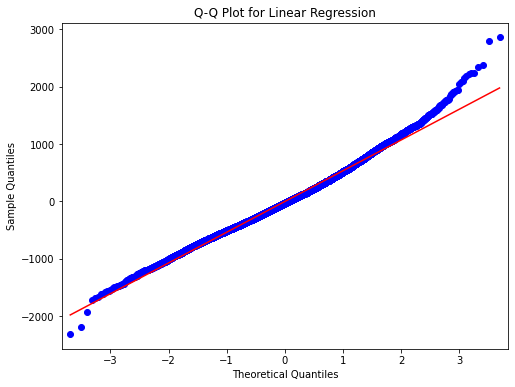

In [ ]:
#QQ plot
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model.resid, ax=ax, line='s' )
plt.title('Q-Q Plot for Linear Regression')
plt.show()

In [ ]:
#The many normality tests for residuals

jb = stats.jarque_bera(model.resid)
sw = stats.shapiro(model.resid)
ad = stats.anderson(model.resid, dist='norm')
ks = stats.kstest(model.resid, 'norm')
    
print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    

Jarque-Bera test ---- statistic: 327.0884, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9920, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5212, p-value: 0.0000
Anderson-Darling test ---- statistic: 16.4482, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


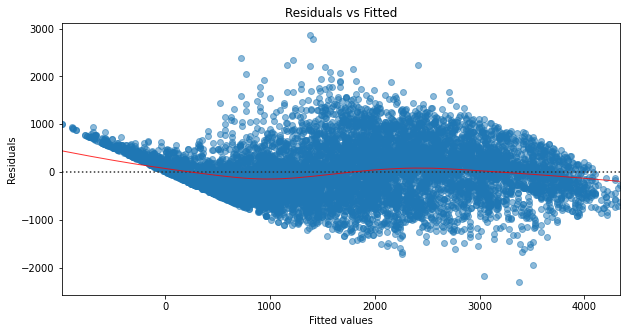

In [ ]:
plot_lm_1 = plt.figure(figsize= (10,5))
plot_lm_1.axes[0] = sns.residplot(model.fittedvalues, y, data=data, 
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# Adding 2 more sites

In [ ]:
solar3 = pd.read_csv(path+"solar_3.csv")
solar4 = pd.read_csv(path+"solar_4.csv")

In [ ]:
solar3.head()

Unnamed: 0                t_stamp_utc    site_id  energy_(Wh)
0           0  2019-01-01 00:00:00+00:00  602393300     298.3292
1           1  2019-01-01 00:05:00+00:00  602393300     372.3139
2           2  2019-01-01 00:10:00+00:00  602393300     260.1569
3           3  2019-01-01 00:15:00+00:00  602393300     372.7456
4           4  2019-01-01 00:20:00+00:00  602393300     372.7708

In [ ]:
solar4.head()

Unnamed: 0                t_stamp_utc    site_id  energy_(Wh)
0           0  2019-01-01 00:00:00+00:00  689045440     270.6033
1           1  2019-01-01 00:05:00+00:00  689045440     262.4325
2           2  2019-01-01 00:10:00+00:00  689045440     337.3475
3           3  2019-01-01 00:15:00+00:00  689045440     142.4900
4           4  2019-01-01 00:20:00+00:00  689045440     373.1419

In [ ]:
solar4["t_stamp_utc"] = pd.to_datetime(solar4["t_stamp_utc"])
solar4["date_time"] = solar4["t_stamp_utc"].dt.tz_convert(timezone("Australia/Brisbane"))
solar4.set_index(solar4["date_time"], inplace=True)
solar4.drop(columns = ["Unnamed: 0", "site_id", "t_stamp_utc", "date_time"], inplace=True)
solar4 = solar4.resample('H').sum()
solar4.head()

energy_(Wh)
date_time                             
2019-01-01 10:00:00+10:00    3671.1074
2019-01-01 11:00:00+10:00    4958.9093
2019-01-01 12:00:00+10:00    4999.5247
2019-01-01 13:00:00+10:00    4997.2592
2019-01-01 14:00:00+10:00    4931.1915

In [ ]:
solar3["t_stamp_utc"] = pd.to_datetime(solar3["t_stamp_utc"])
solar3["date_time"] = solar3["t_stamp_utc"].dt.tz_convert(timezone("Australia/Brisbane"))
solar3.set_index(solar3["date_time"], inplace=True)
solar3.drop(columns = ["Unnamed: 0", "site_id", "t_stamp_utc", "date_time"], inplace=True)
solar3 = solar3.resample('H').sum()
solar3.head()

energy_(Wh)
date_time                             
2019-01-01 10:00:00+10:00    4151.2156
2019-01-01 11:00:00+10:00    4374.4255
2019-01-01 12:00:00+10:00    4460.1522
2019-01-01 13:00:00+10:00    4458.7004
2019-01-01 14:00:00+10:00    4007.5898

In [ ]:
temp3 = pd.merge(solar3, weather, how="left", on= "date_time")
data3 = pd.merge(temp3, sol, how="left", on= "date_time")
data3.rename(columns= {"energy_(Wh)": "energy"}, inplace=True)
data3 = data3.dropna()
data3.head()

energy  uvIndex  ...  GtiFixedTilt  GtiTracking
date_time                                      ...                           
2019-01-01 10:00:00+10:00  4151.2156      7.0  ...           955         1080
2019-01-01 11:00:00+10:00  4374.4255      7.0  ...          1019         1089
2019-01-01 12:00:00+10:00  4460.1522      7.0  ...          1007         1088
2019-01-01 13:00:00+10:00  4458.7004      7.0  ...           920         1075
2019-01-01 14:00:00+10:00  4007.5898      7.0  ...           766         1046

[5 rows x 17 columns]

In [ ]:
temp4 = pd.merge(solar4, weather, how="left", on= "date_time")
data4 = pd.merge(temp4, sol, how="left", on= "date_time")
data4.rename(columns= {"energy_(Wh)": "energy"}, inplace=True)
data4 = data4.dropna()
data4.head()

energy  uvIndex  ...  GtiFixedTilt  GtiTracking
date_time                                      ...                           
2019-01-01 10:00:00+10:00  3671.1074      7.0  ...           955         1080
2019-01-01 11:00:00+10:00  4958.9093      7.0  ...          1019         1089
2019-01-01 12:00:00+10:00  4999.5247      7.0  ...          1007         1088
2019-01-01 13:00:00+10:00  4997.2592      7.0  ...           920         1075
2019-01-01 14:00:00+10:00  4931.1915      7.0  ...           766         1046

[5 rows x 17 columns]

In [ ]:
#drop all rows for which there is no sunlight
data3.drop(data3[data3['energy'] < 5].index, inplace = True)

#droppin THOSE clear outliers
data3.drop(data3[data3["energy"]>5500].index, inplace = True)

#drop the row that has 0 temp
data3.drop(data3[data3["tempC"]<2].index, inplace = True)

In [ ]:
#drop all rows for which there is no sunlight
data4.drop(data4[data4['energy'] < 5].index, inplace = True)

#droppin THOSE clear outliers
data4.drop(data4[data4["energy"]>5100].index, inplace = True)

#drop the row that has 0 temp
data4.drop(data4[data4["tempC"]<2].index, inplace = True)

In [ ]:
data3.drop(columns=["DNI",	"EBH", "GtiFixedTilt",	"GtiTracking"], inplace=True)
data4.drop(columns=["DNI",	"EBH", "GtiFixedTilt",	"GtiTracking"], inplace=True)

In [ ]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['energy', "uvIndex",	"cloudcover",	"humidity",	"precipMM",	"pressure",	"tempC"	,"visibility"	,"winddirDegree",	"windspeedKmph", "Albedo",	"DHI",		"GHI"]
# Resample to weekly frequency, aggregating with mean
data_weekly_mean = data3[data_columns].resample('W').mean()
# Resample to daily frequency, aggregating with mean
data_daily_mean = data3[data_columns].resample('D').mean()

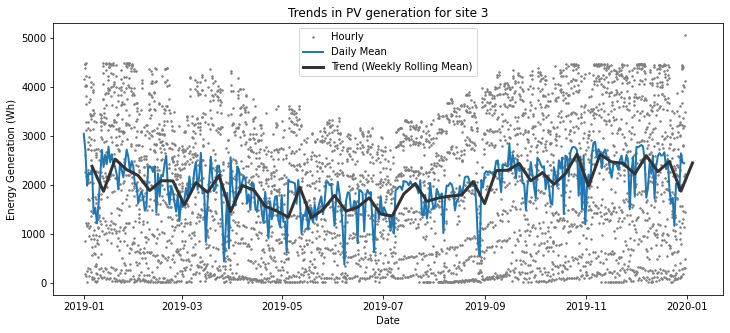

In [ ]:
# Plot hourly, daily rolling mean, and 7-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(data3['energy'], marker='.', markersize=3, color='0.5',
linestyle='None',  label='Hourly')
ax.plot(data_daily_mean['energy'], linewidth=2, label='Daily Mean')
ax.plot(data_weekly_mean['energy'], color='0.2', linewidth=3,
label='Trend (Weekly Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
fig.set_figheight(5)
fig.set_figwidth(12)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Energy Generation (Wh)')
ax.set_title('Trends in PV generation for site 3');

In [ ]:
# Specify the data columns we want to include (i.e. exclude Year, Month, Weekday Name)
data_columns = ['energy', "uvIndex",	"cloudcover",	"humidity",	"precipMM",	"pressure",	"tempC"	,"visibility"	,"winddirDegree",	"windspeedKmph", "Albedo",	"DHI",		"GHI"]
# Resample to weekly frequency, aggregating with mean
data_weekly_mean = data4[data_columns].resample('W').mean()
# Resample to daily frequency, aggregating with mean
data_daily_mean = data4[data_columns].resample('D').mean()

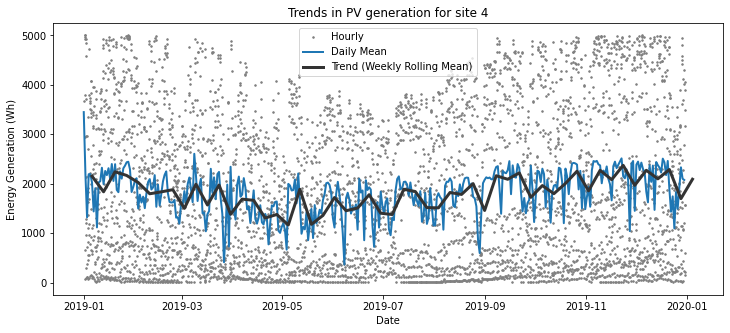

In [ ]:
# Plot hourly, daily rolling mean, and 7-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(data4['energy'], marker='.', markersize=3, color='0.5',
linestyle='None',  label='Hourly')
ax.plot(data_daily_mean['energy'], linewidth=2, label='Daily Mean')
ax.plot(data_weekly_mean['energy'], color='0.2', linewidth=3,
label='Trend (Weekly Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
fig.set_figheight(5)
fig.set_figwidth(12)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Energy Generation (Wh)')
ax.set_title('Trends in PV generation for site 4');

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8878 entries, 2019-01-01 10:00:00+10:00 to 2019-12-31 18:00:00+10:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   energy         8878 non-null   float64
 1   uvIndex        8878 non-null   float64
 2   cloudcover     8878 non-null   float64
 3   humidity       8878 non-null   float64
 4   precipMM       8878 non-null   float64
 5   pressure       8878 non-null   float64
 6   tempC          8878 non-null   float64
 7   visibility     8878 non-null   float64
 8   winddirDegree  8878 non-null   float64
 9   windspeedKmph  8878 non-null   float64
 10  Albedo         8878 non-null   float64
 11  DHI            8878 non-null   int64  
 12  GHI            8878 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 971.0 KB


In [ ]:
data = data.append(data3)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13326 entries, 2019-01-01 10:00:00+10:00 to 2019-12-31 18:00:00+10:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   energy         13326 non-null  float64
 1   uvIndex        13326 non-null  float64
 2   cloudcover     13326 non-null  float64
 3   humidity       13326 non-null  float64
 4   precipMM       13326 non-null  float64
 5   pressure       13326 non-null  float64
 6   tempC          13326 non-null  float64
 7   visibility     13326 non-null  float64
 8   winddirDegree  13326 non-null  float64
 9   windspeedKmph  13326 non-null  float64
 10  Albedo         13326 non-null  float64
 11  DHI            13326 non-null  int64  
 12  GHI            13326 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1.4 MB


In [ ]:
data = data.append(data4)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17860 entries, 2019-01-01 10:00:00+10:00 to 2019-12-31 18:00:00+10:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   energy         17860 non-null  float64
 1   uvIndex        17860 non-null  float64
 2   cloudcover     17860 non-null  float64
 3   humidity       17860 non-null  float64
 4   precipMM       17860 non-null  float64
 5   pressure       17860 non-null  float64
 6   tempC          17860 non-null  float64
 7   visibility     17860 non-null  float64
 8   winddirDegree  17860 non-null  float64
 9   windspeedKmph  17860 non-null  float64
 10  Albedo         17860 non-null  float64
 11  DHI            17860 non-null  int64  
 12  GHI            17860 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1.9 MB


In [ ]:
import statsmodels.api as sm
X = data.iloc[:,1:]
X_con = sm.add_constant(X)
y = data["energy"]
logit_model=sm.OLS(y,X_con)
result=logit_model.fit()
print(result.summary2())

                    Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.790      
Dependent Variable:  energy            AIC:                 280059.9234
Date:                2020-10-22 04:59  BIC:                 280161.1975
No. Observations:    17860             Log-Likelihood:      -1.4002e+05
Df Model:            12                F-statistic:         5591.      
Df Residuals:        17847             Prob (F-statistic):  0.00       
R-squared:           0.790             Scale:               3.7785e+05 
-----------------------------------------------------------------------
                Coef.     Std.Err.    t     P>|t|    [0.025     0.975] 
-----------------------------------------------------------------------
const            12.8365 1343.6115   0.0096 0.9924 -2620.7724 2646.4453
uvIndex        -217.9907    7.1939 -30.3020 0.0000  -232.0915 -203.8899
cloudcover       -1.3138    0.2175  -6.0412 0.0000    -1.7401   -0.8876
humidity    

In [ ]:
model = forward_selected(data, "energy")

In [ ]:
print(model.model.formula)

energy ~ GHI + winddirDegree + humidity + DHI + uvIndex + tempC + windspeedKmph + cloudcover + visibility + precipMM + Albedo + pressure + 1


In [ ]:
print(model.summary2())

                    Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.790      
Dependent Variable:  energy            AIC:                 280059.9234
Date:                2020-10-22 04:59  BIC:                 280161.1975
No. Observations:    17860             Log-Likelihood:      -1.4002e+05
Df Model:            12                F-statistic:         5591.      
Df Residuals:        17847             Prob (F-statistic):  0.00       
R-squared:           0.790             Scale:               3.7785e+05 
-----------------------------------------------------------------------
                Coef.     Std.Err.    t     P>|t|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        12.8365 1343.6115   0.0096 0.9924 -2620.7724 2646.4453
GHI               3.2458    0.0218 148.8487 0.0000     3.2031    3.2886
winddirDegree    -1.8034    0.0687 -26.2670 0.0000    -1.9379   -1.6688
humidity    

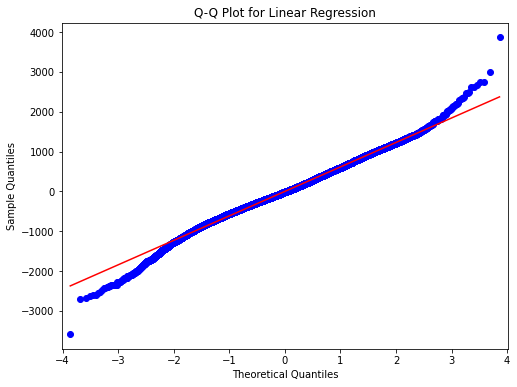

In [ ]:
#QQ plot
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model.resid, ax=ax, line='s' )
plt.title('Q-Q Plot for Linear Regression')
plt.show()

In [ ]:
#The many normality tests for residuals

jb = stats.jarque_bera(model.resid)
sw = stats.shapiro(model.resid)
ad = stats.anderson(model.resid, dist='norm')
ks = stats.kstest(model.resid, 'norm')
    
print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    

Jarque-Bera test ---- statistic: 658.0158, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9936, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5087, p-value: 0.0000
Anderson-Darling test ---- statistic: 19.0535, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


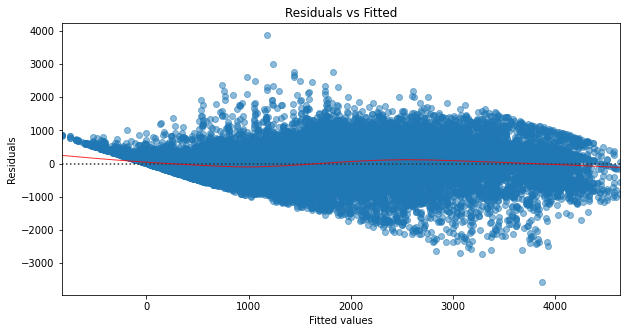

In [ ]:
plot_lm_1 = plt.figure(figsize= (10,5))
plot_lm_1.axes[0] = sns.residplot(model.fittedvalues, y, data=data, 
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

[79.21996472394252, 5.0661873759650975, 49.52945154951327, 1.31006265467055, 701.0197657182983, 92.59279275252989, 31.963416278800672, 5.598493416975222, 8.17700934075517, 585.8106644010996, 4.255135586723251, 6.21581799984193]


In [ ]:
X.columns

Index(['uvIndex', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC',
       'visibility', 'winddirDegree', 'windspeedKmph', 'Albedo', 'DHI', 'GHI'],
      dtype='object')

In [ ]:
X_new = X.copy()
X_new.drop(columns="pressure", inplace=True)

In [ ]:
vif = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]

print(vif)

[78.91079059177753, 5.0297702281336925, 43.99382737583619, 1.3028995008438198, 92.59273079610486, 31.357784052189743, 5.477140831051618, 7.8196191044239205, 110.26565660702671, 4.201884291590243, 5.801893818923932]


In [ ]:
X_new.drop(columns="Albedo", inplace=True)
vif = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]

print(vif)

[77.69781316354309, 5.02249608095778, 34.887771532714275, 1.2979303581596664, 84.89668195470942, 27.207121944174016, 4.546436820462577, 7.278621617453011, 4.186015582131757, 5.699186560586831]


In [ ]:
X_new.drop(columns="tempC", inplace=True)
vif = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]

print(vif)

[32.74059487559227, 4.964048978191224, 34.79229718032842, 1.2793413106346787, 26.369150274523914, 4.33208548847024, 6.694271983695156, 4.152279438987736, 5.215000226636167]


In [ ]:
X_new.drop(columns="humidity", inplace=True)
vif = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]

print(vif)

[22.83406536497225, 3.391064752926437, 1.2271253309139032, 22.957882057213915, 4.259156248038078, 6.690726470028087, 4.1507911525560255, 4.895024386939617]


In [ ]:
X_new.drop(columns="uvIndex", inplace=True)
vif = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]

print(vif)

[3.391039118504854, 1.215858518578194, 12.217598614767907, 4.238011176143757, 6.166639946038693, 4.114969217057236, 4.633428964467611]


In [ ]:
X_new.drop(columns="visibility", inplace=True)
vif = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]

print(vif)

[3.115226660883138, 1.1846762557546726, 2.713287917813701, 4.427154564056679, 4.114850196039655, 4.1152983087113055]


In [ ]:
X_new.drop(columns="winddirDegree", inplace=True)

In [ ]:
data.drop(columns=["winddirDegree", "visibility", "uvIndex", "humidity", "tempC", "Albedo", "pressure", "precipMM"], inplace=True)

In [ ]:
model = forward_selected(data, "energy")

In [ ]:
print(model.model.formula)

energy ~ GHI + windspeedKmph + DHI + cloudcover + 1


In [ ]:
print(model.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.751      
Dependent Variable: energy           AIC:                283097.1995
Date:               2020-10-22 05:13 BIC:                283136.1511
No. Observations:   17860            Log-Likelihood:     -1.4154e+05
Df Model:           4                F-statistic:        1.344e+04  
Df Residuals:       17855            Prob (F-statistic): 0.00       
R-squared:          0.751            Scale:              4.4809e+05 
--------------------------------------------------------------------
                 Coef.   Std.Err.    t     P>|t|    [0.025   0.975] 
--------------------------------------------------------------------
Intercept      -125.1077  16.6913  -7.4954 0.0000 -157.8243 -92.3911
GHI               3.6152   0.0211 171.4144 0.0000    3.5739   3.6566
windspeedKmph    20.0937   0.8454  23.7672 0.0000   18.4365  21.7508
DHI               0.9655   0.0494  19.5337 0.0000    

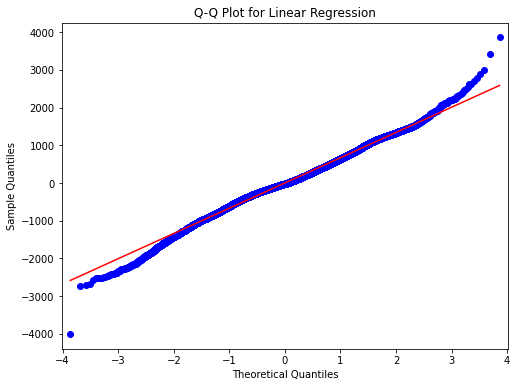

In [ ]:
#QQ plot
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model.resid, ax=ax, line='s' )
plt.title('Q-Q Plot for Linear Regression')
plt.show()

In [ ]:
#The many normality tests for residuals

jb = stats.jarque_bera(model.resid)
sw = stats.shapiro(model.resid)
ad = stats.anderson(model.resid, dist='norm')
ks = stats.kstest(model.resid, 'norm')
    
print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    

Jarque-Bera test ---- statistic: 530.6211, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9926, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5137, p-value: 0.0000
Anderson-Darling test ---- statistic: 42.9185, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


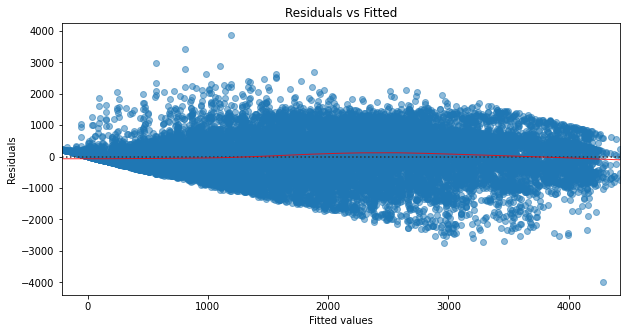

In [ ]:
plot_lm_1 = plt.figure(figsize= (10,5))
plot_lm_1.axes[0] = sns.residplot(model.fittedvalues, y, data=data, 
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');